In [1]:
import sys
sys.path.append('..')

import optimus
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
import numpy as np
from optimus.source.transducers import transducer_field
from optimus.postprocess.plot import surface_plot

from utilities import FiniteDifference, RectangularPulse, TurkPulse

In [2]:
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')

c_0 = material_ext.speed_of_sound
rho_0 = material_ext.density
C_t = material_ext.heat_capacity 
k_t = material_ext.thermal_conductivity
eta = material_ext.attenuation_pow_b 
alpha_0 = material_ext.attenuation_coeff_a 

frequency = 500e3

Nx = 51
Ny = 51
Nz = 101

xmin, xmax, ymin, ymax, zmin, zmax = [-0.03, 0.03, -0.03, 0.03, 0, 0.12]

delta_x = (xmax - xmin) / Nx
delta_y = (ymax - ymin) / Ny
delta_z = (zmax - zmin) / Nz

# Read file with IPP

In [3]:
IPP_abs_load = np.loadtxt("HEAD_1ms.txt")

IPP_abs = IPP_abs_load.reshape(
    IPP_abs_load.shape[0], IPP_abs_load.shape[1] // 51, 51) 

In [4]:
np.max(IPP_abs)

27287987.65730765

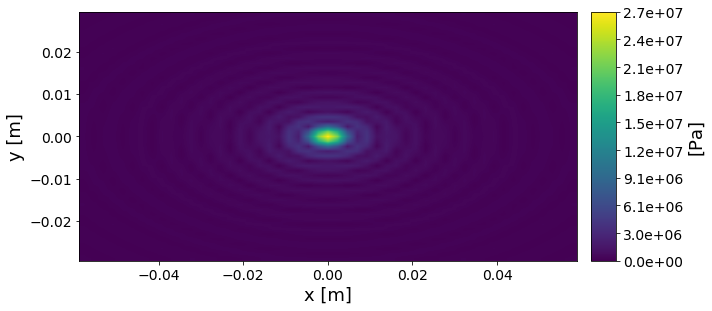

In [20]:
z_layer = IPP_abs[52]
fig = surface_plot(z_layer,
                   axes_lims=(delta_x * (-50), delta_x * (50), 
                              delta_y * (-25), delta_y * (25)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[0, 27287988],
                   colorbar_unit="[Pa]",
                   )

# Calculate heat deposition

In [6]:
intensity = (IPP_abs)**2 / (2 * c_0 * rho_0)
alpha = alpha_0 * frequency / 1000000
heat_deposition = intensity.copy()
heat_deposition = 2 * alpha * intensity

In [7]:
np.max(heat_deposition)

6400050.631198212

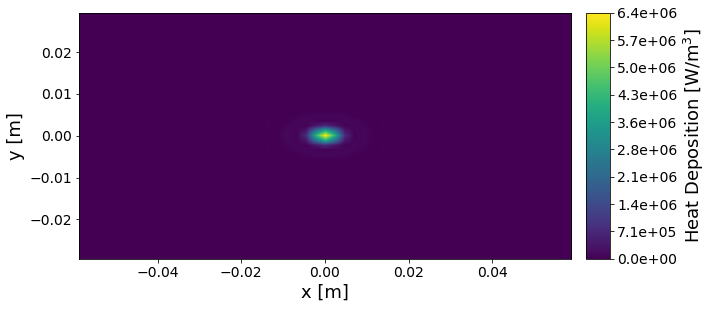

In [21]:
z_layer = heat_deposition[52]
fig = surface_plot(z_layer,
                   axes_lims=(delta_x * (-50), delta_x * (50), 
                              delta_y * (-25), delta_y * (25)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[0, 6400051],
                   colorbar_unit="Heat Deposition [W/m$^3$]",
                   )

In [9]:
i,j,k = np.unravel_index(heat_deposition.argmax(), heat_deposition.shape)

In [10]:
heat_deposition[i][j][k]

6400050.631198212

# Estimate temperature with real params

In [11]:
delta_t = 2e-5
Nt = int(1.5e4)
T_0 = np.zeros_like(heat_deposition) + 37

max_temp_ramp = []
max_temp_rect = []
max_temp_noat = []

prev_temp_ramp = T_0
prev_temp_rect = T_0
prev_temp_noat = T_0

time_domain = np.array(range(Nt)) * delta_t
rect_pulses = RectangularPulse(time_domain)
ramp_pulses = TurkPulse(time_domain)

In [12]:
%%time
for i in range(Nt):
    max_temp_ramp.append(np.max(prev_temp_ramp))
    max_temp_rect.append(np.max(prev_temp_rect))
    max_temp_noat.append(np.max(prev_temp_noat))
    
    prev_temp_ramp = FiniteDifference(temp_grid=prev_temp_ramp, 
                                      heat_deposition=heat_deposition, 
                                      attenuation=ramp_pulses[i],
                                      delta_x=delta_x,
                                      delta_y=delta_y,
                                      delta_z=delta_z,
                                      delta_t=delta_t)
    
    prev_temp_rect = FiniteDifference(temp_grid=prev_temp_rect, 
                                      heat_deposition=heat_deposition, 
                                      attenuation=rect_pulses[i],
                                      delta_x=delta_x,
                                      delta_y=delta_y,
                                      delta_z=delta_z,
                                      delta_t=delta_t)
    
    prev_temp_noat = FiniteDifference(temp_grid=prev_temp_noat, 
                                      heat_deposition=heat_deposition, 
                                      attenuation=1,
                                      delta_x=delta_x,
                                      delta_y=delta_y,
                                      delta_z=delta_z,
                                      delta_t=delta_t)

CPU times: user 13min 7s, sys: 5.9 ms, total: 13min 7s
Wall time: 13min 7s


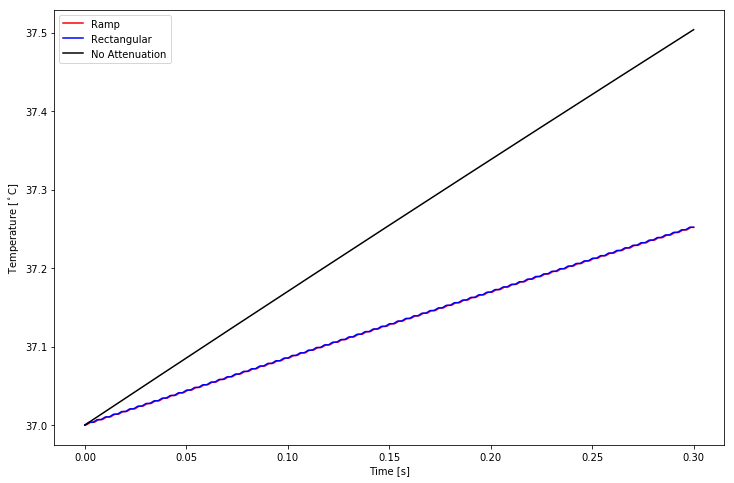

In [13]:
fig = plt.figure(figsize = (12,8))

plt.plot(time_domain, max_temp_ramp, c='red', label = 'Ramp')
plt.plot(time_domain, max_temp_rect, c='blue', label = 'Rectangular')
plt.plot(time_domain, max_temp_noat, c='black', label = 'No Attenuation')

plt.legend(loc = 'upper left')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [$^\circ$C]')
plt.show()

# Run experiment for long period of time and turn off source.

In [14]:
delta_t_2 = 2e-2
Nt_2 = int(4e4)
T_0 = np.zeros_like(heat_deposition) + 37

max_temp_noat_2 = []

prev_temp_noat_2 = T_0

time_domain_2 = np.array(range(Nt_2)) * delta_t_2

In [15]:
%%time
for i in range(Nt_2):
    max_temp_noat_2.append(np.max(prev_temp_noat_2))
    
    prev_temp_noat_2 = FiniteDifference(temp_grid=prev_temp_noat_2, 
                                      heat_deposition=heat_deposition, 
                                      attenuation=1,
                                      delta_x=delta_x,
                                      delta_y=delta_y,
                                      delta_z=delta_z,
                                      delta_t=delta_t_2)

CPU times: user 11min 28s, sys: 15.6 ms, total: 11min 28s
Wall time: 11min 28s


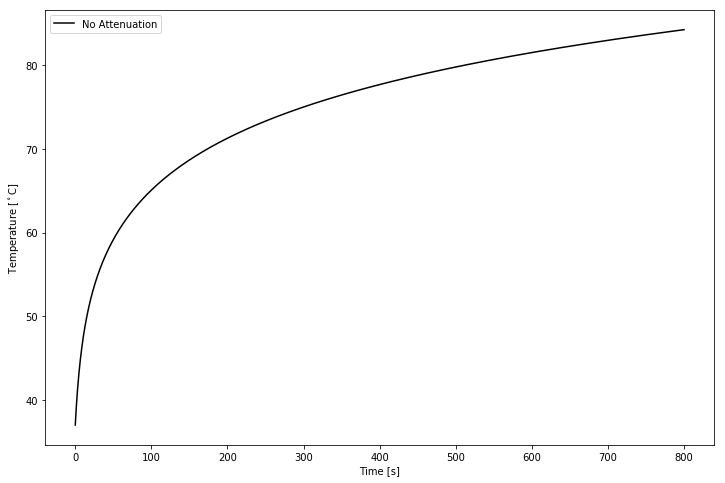

In [16]:
fig = plt.figure(figsize = (12,8))

plt.plot(time_domain_2, max_temp_noat_2, c='black', label = 'No Attenuation')

plt.legend(loc = 'upper left')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [$^\circ$C]')
plt.show()

In [17]:
%%time
for i in range(Nt_2):
    max_temp_noat_2.append(np.max(prev_temp_noat_2))
    
    prev_temp_noat_2 = FiniteDifference(temp_grid=prev_temp_noat_2, 
                                      heat_deposition=heat_deposition, 
                                      attenuation=0,
                                      delta_x=delta_x,
                                      delta_y=delta_y,
                                      delta_z=delta_z,
                                      delta_t=delta_t_2)

CPU times: user 13min 18s, sys: 46 ms, total: 13min 18s
Wall time: 13min 18s


In [18]:
time_domain_2 = np.array(range(Nt_2 * 2)) * delta_t_2

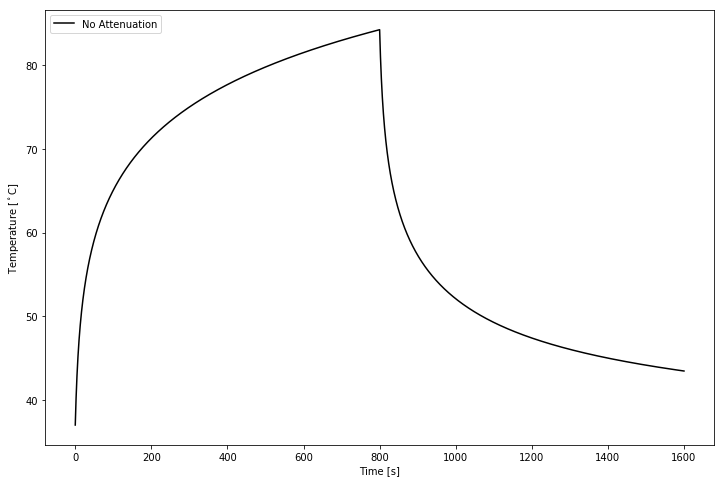

In [19]:
fig = plt.figure(figsize = (12,8))

plt.plot(time_domain_2, max_temp_noat_2, c='black', label = 'No Attenuation')

plt.legend(loc = 'upper left')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [$^\circ$C]')
plt.show()

 - Probar velocidad x10 y 1 m/s (50 / 100 grados de delta)
 - Validar resultados 
 - 1 layer b=0 (orig 3.5)